# Sentiment Analysis on Twitter Data Using Classical ML & DistilBERT

## 1. Introduction & Project Goals

This notebook performs multi-class sentiment classification on real Twitter data using both classical approaches and modern deep learning techniques.

### Models Implemented
* **Classical Machine Learning:**
  * Logistic Regression
  * Naive Bayes
* **Transformer-based Deep Learning:**
  * DistilBERT (fine-tuned using HuggingFace + TensorFlow)

### Target Classes
We classify tweets into the following sentiments:
* **Negative (-1)**
* **Neutral (0)**
* **Positive (1)**

# 2. Project Workflow

This project demonstrates a complete end-to-end NLP pipeline, specifically designed as a portfolio-quality project. The workflow includes:

* Data cleaning
* TF-IDF vectorization
* Model training
* BERT fine-tuning
* Final model evaluation & comparison

## 3. Importing Libraries
We will use **Scikit-Learn** for classical machine learning and **Hugging Face Transformers** with **TensorFlow** for the deep learning component.

In [1]:
# ================================
#  Importing Required Libraries
# ================================

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP preprocessing
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Transformer model (DistilBERT)
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
import tensorflow as tf

# Settings for clean visuals
sns.set(style="whitegrid")
plt.style.use("ggplot")

# NLTK downloads
nltk.download('stopwords')
nltk.download('wordnet')

print("Libraries imported successfully!")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Libraries imported successfully!


## 4. Data Loading and Exploration
We load the dataset and inspect the first few rows to understand the structure of the tweets and their sentiment labels.

In [2]:
# =========================
#  Loading the Dataset
# =========================

# Load the CSV file
df=pd.read_csv('/content/Twitter_Data.csv')

# DataFrame view
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


### 4.1 Basic EDA
Let's check the dataset dimensions, column names, and data types to ensure everything loaded correctly.

In [3]:
# ============================
#  Basic Exploratory Analysis
# ============================

# Show dataset shape
print("Dataset Shape:", df.shape)

# Show column names
print("\nColumn Names:", df.columns.tolist())

# Check data types
print("\nData Types:\n", df.dtypes)

Dataset Shape: (162980, 2)

Column Names: ['clean_text', 'category']

Data Types:
 clean_text     object
category      float64
dtype: object


### 4.2 Handling Missing Values
We check for null values. Since the number of missing rows is negligible compared to the dataset size, we will drop them to maintain data quality.

In [4]:
# Check missing values
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 clean_text    4
category      7
dtype: int64


In [5]:
# Drop rows with ANY missing values
df.dropna(inplace=True)

In [6]:
# Convert category to int
df['category']=df['category'].astype(int)

### 4.3 Class Distribution
It is crucial to check if the dataset is balanced. We visualize the count of Negative (-1), Neutral (0), and Positive (1) tweets.

In [7]:
# Check label distribution
print("\nLabel Distribution:\n",df['category'].value_counts())


Label Distribution:
 category
 1    72249
 0    55211
-1    35509
Name: count, dtype: int64


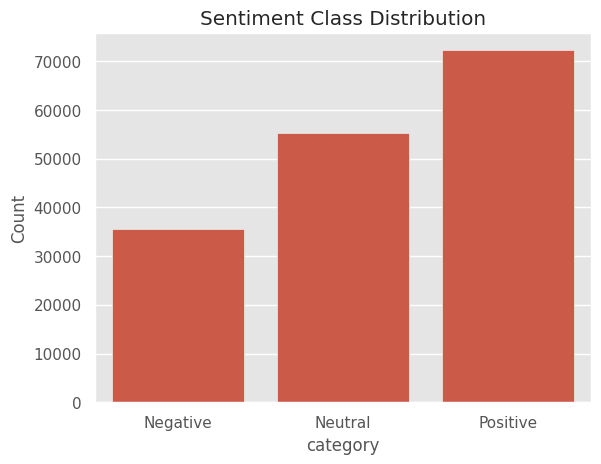

In [8]:
# Plot label distribution
sns.countplot(data=df, x='category')
plt.title("Sentiment Class Distribution")
plt.xticks([0,1,2],['Negative','Neutral','Positive'])
plt.ylabel("Count")
plt.show()

## 5. Text Preprocessing
We implement two different cleaning strategies:
1.  **For Classical ML:** "Scorched Earth" approach. We remove numbers, punctuation, emojis, and stopwords to leave only essential keywords.
2.  **For BERT:** Light cleaning. We keep punctuation and sentence structure because BERT relies on context.

In [9]:
# =====================================
#  Text Cleaning Functions for NLP
# =====================================

# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_for_ml(text):
  """
    Full cleaning for classical ML models.
  """

  # Lowercase
  text= text.lower()

  # Remove URLs
  text = re.sub(r'http\S+|www\S+','',text)

  # Remove @mentions
  text = re.sub(r'@\w+','',text)

  # Remove punctuation, digits, emojis — keep only letters a-z
  text = re.sub(r'[^a-z\s]','',text)

  # Remove extra spaces
  text = text.strip()

  # Tokenize
  words = text.split()

  # Remove stopwords + lemmatize
  words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]

  # Rejoin
  return " ".join(words)

def clean_for_bert(text):
  """
    Light cleaning for BERT.
  """

  # Remove URLs
  text = re.sub(r'http\S+|www\S+','',text)

  # Remove mentions
  text = re.sub(r'@\w+','',text)

  # Remove extra spaces
  text = text.strip()

  return text


# Apply cleaning
df['clean_text_ml']=df['clean_text'].apply(clean_for_ml)
df['clean_text_bert']=df['clean_text'].apply(clean_for_bert)

df[['clean_text', 'clean_text_ml', 'clean_text_bert']].head()

,clean_text,clean_text_ml,clean_text_bert
0,when modi promised “minimum government maximum...,modi promised minimum government maximum gover...,when modi promised “minimum government maximum...
1,talk all the nonsense and continue all the dra...,talk nonsense continue drama vote modi,talk all the nonsense and continue all the dra...
2,what did just say vote for modi welcome bjp t...,say vote modi welcome bjp told rahul main camp...,what did just say vote for modi welcome bjp t...
3,asking his supporters prefix chowkidar their n...,asking supporter prefix chowkidar name modi gr...,asking his supporters prefix chowkidar their n...
4,answer who among these the most powerful world...,answer among powerful world leader today trump...,answer who among these the most powerful world...


## 6. Classical Machine Learning Models
### 6.1 TF-IDF Vectorization
We convert the text into numerical vectors using **TF-IDF (Term Frequency-Inverse Document Frequency)**. We keep the top 10,000 most frequent features.

In [10]:
# ================================
#  Train–Test Split + TF-IDF
# ================================

X=df['clean_text_ml']
y=df['category']

# Train-test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

# TF-IDF Vectorizer
tfidf= TfidfVectorizer(max_features=10000)

# Fit on training data only
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform test data
X_test_tfidf = tfidf.transform(X_test)

print("\nVectorization Complete!")

print("Shape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of X_test_tfidf:", X_test_tfidf.shape)


Vectorization Complete!
Shape of X_train_tfidf: (130375, 10000)
Shape of X_test_tfidf: (32594, 10000)


### 6.2 Model 1: Logistic Regression
We train a Logistic Regression model using the "One-vs-Rest" strategy for multi-class classification.

In [11]:
# ================================
#  Logistic Regression Baseline
# ================================

log_reg= LogisticRegression(max_iter=2000,n_jobs=-1)

# Train the model
log_reg.fit(X_train_tfidf,y_train)

# Predict on test data
y_pred_lr=log_reg.predict(X_test_tfidf)

# Evaluate
print("Logistic Regression Accuracy:", accuracy_score(y_test,y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test,y_pred_lr))

Logistic Regression Accuracy: 0.8844265815794318

Classification Report:
               precision    recall  f1-score   support

          -1       0.87      0.76      0.81      7102
           0       0.85      0.96      0.90     11042
           1       0.92      0.89      0.90     14450

    accuracy                           0.88     32594
   macro avg       0.88      0.87      0.87     32594
weighted avg       0.89      0.88      0.88     32594



### 6.3 Model 2: Naive Bayes
We train a Multinomial Naive Bayes classifier, which is a standard baseline for text classification tasks due to its speed and effectiveness with high-dimensional data.

In [12]:
# ============================
#  Naive Bayes Classifier
# ============================

nb=MultinomialNB()

# Train model
nb.fit(X_train_tfidf,y_train)

# Predict
y_pred_nb=nb.predict(X_test_tfidf)

# Evaluate
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.7103454623550347

Classification Report:
               precision    recall  f1-score   support

          -1       0.86      0.41      0.55      7102
           0       0.82      0.62      0.71     11042
           1       0.64      0.92      0.76     14450

    accuracy                           0.71     32594
   macro avg       0.77      0.65      0.67     32594
weighted avg       0.75      0.71      0.70     32594



### 6.4 Classical Model Evaluation
We compare the accuracy of Logistic Regression vs. Naive Bayes and visualize their Confusion Matrices to see where they make errors.

Logistic Regression Accuracy: 0.8844265815794318
Naive Bayes Accuracy: 0.7103454623550347


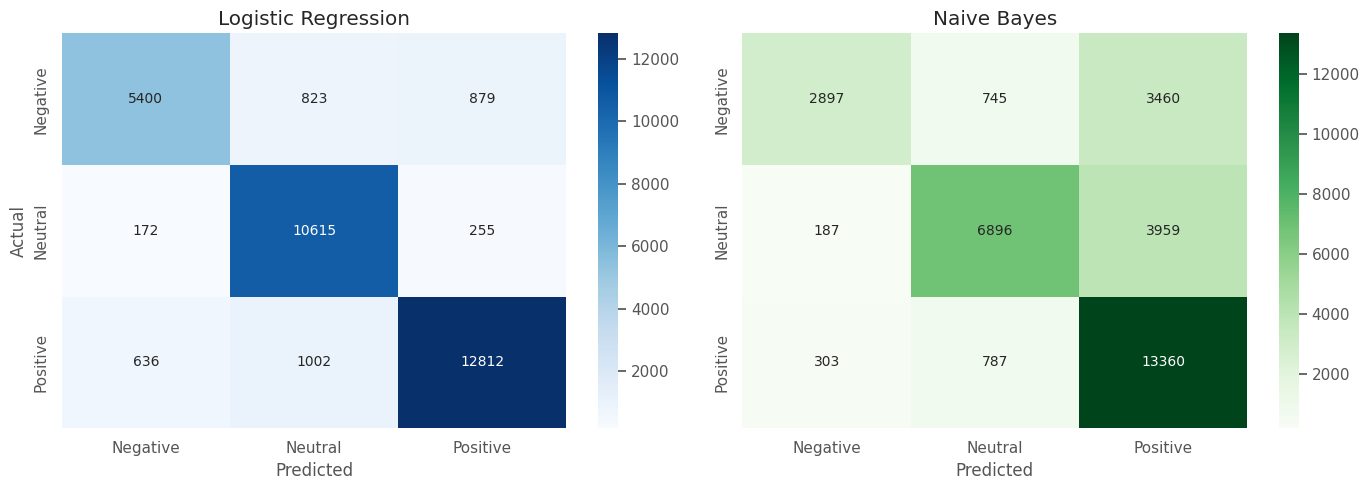

In [13]:
# ================================
#  Compare Models + Confusion Matrix
# ================================

# Model Accuracies
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrices
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_nb = confusion_matrix(y_test, y_pred_nb)

# Labels
labels = ['Negative', 'Neutral', 'Positive']

# Logistic Regression
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title("Logistic Regression")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Naive Bayes
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title("Naive Bayes")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

## 7. Deep Learning: Fine-Tuning DistilBERT
### 7.1 Tokenization and Encoding
We map the labels from `{-1, 0, 1}` to `{0, 1, 2}` for TensorFlow. Then, we use the **DistilBERT Tokenizer** to convert text into Input IDs and Attention Masks.

In [15]:
# =====================================
#  DistilBERT Tokenization & Encoding
# =====================================

# Create labels for BERT (no negative numbers allowed)
df['bert_label']=df['category']+1

# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Encode the BERT-clean text
encodings = tokenizer(df['clean_text_bert'].tolist(),truncation=True,padding=True,max_length=64,return_tensors='tf')

# Extract input IDs and attention masks
input_ids=encodings['input_ids']
attention_masks=encodings['attention_mask']

# Labels (target)
labels=tf.constant(df['bert_label'].values)

print("Tokenization complete!")
print("Input IDs shape:", input_ids.shape)
print("Attention mask shape:", attention_masks.shape)
print("Labels shape:", labels.shape)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Tokenization complete!
Input IDs shape: (162969, 64)
Attention mask shape: (162969, 64)
Labels shape: (162969,)


### 7.2 Prepare Data for TensorFlow
We split the tokenized inputs into training and testing sets, ensuring stratified sampling to maintain class balance.

In [16]:
# =====================================
#  Train-Test Split for DistilBERT
# =====================================

# Convert tensors to numpy for splitting
input_ids_np= input_ids.numpy()
attention_masks_np= attention_masks.numpy()
labels_np= labels.numpy()

# Split into train and test sets
X_train_ids,X_test_ids,X_train_masks,X_test_masks,y_train_bert,y_test_bert=train_test_split(input_ids_np,attention_masks_np,labels_np,test_size=0.2,random_state=42,stratify=labels_np)

print("Train/Test split complete!")
print("Train input shape:", X_train_ids.shape)
print("Test input shape:", X_test_ids.shape)


Train/Test split complete!
Train input shape: (130375, 64)
Test input shape: (32594, 64)


### 7.3 Creating TensorFlow Pipelines
We convert the arrays into `tf.data.Dataset` objects. This allows for efficient data streaming, batching, and caching during model training.

In [18]:
# =====================================
#  Create tf.data Datasets for BERT
# =====================================
BATCH_SIZE= 16

def make_dataset(input_ids,attention_masks, labels,shuffle=False, batch_size=16):
    # Create dataset:
    ds = tf.data.Dataset.from_tensor_slices(({"input_ids":input_ids,"attention_mask": attention_masks},labels))
    # Shuffle only for training
    if shuffle:
      ds = ds.shuffle(2048)
    # Batch and prefetch for speed
    ds= ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return ds

# Create training dataset (shuffled)
train_ds= make_dataset(X_train_ids,X_train_masks,y_train_bert,shuffle=True,batch_size=BATCH_SIZE)

# Create validation dataset
val_ds= make_dataset(X_test_ids,X_test_masks,y_test_bert,shuffle=False,batch_size=BATCH_SIZE)

# Preview ONE batch to confirm shapes
for batch_inputs, batch_labels in train_ds.take(1):
    print("One batch input_ids:", batch_inputs['input_ids'].shape)
    print("One batch attention_mask:", batch_inputs['attention_mask'].shape)
    print("One batch labels:", batch_labels.shape)

One batch input_ids: (16, 64)
One batch attention_mask: (16, 64)
One batch labels: (16,)


### 7.4 Load and Compile DistilBERT
We load the pre-trained `distilbert-base-uncased` model and attach a classification head for 3 classes. We use a low learning rate (`3e-5`) to avoid destroying the pre-trained weights.

In [20]:
# =====================================
# Load & Compile DistilBERT
# =====================================

NUM_LABELS = 3

# Load pretrained model
with tf.device('/GPU:0'):
    model= TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=NUM_LABELS,from_pt=True)

# Compile model
optimizer= tf.keras.optimizers.Adam(learning_rate=3e-5)
loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

# Show model summary
model.summary()

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'cla

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 66955779 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 7.5 Model Training
We fine-tune the model. Even a single epoch can yield very high accuracy due to the transfer learning capabilities of BERT.

In [21]:
# =====================================
#  DistilBERT Test (1 epoch)
# =====================================

history= model.fit(train_ds,validation_data=val_ds,epochs=1,verbose=1)

8149/8149 [==============================] - 1500s 176ms/step - loss: 0.1868 - accuracy: 0.9358 - val_loss: 0.0961 - val_accuracy: 0.9679


## 8. Final Evaluation
We evaluate the fine-tuned DistilBERT model on the test set and generate a classification report.

In [27]:
# =============================
# Evaluate DistilBERT
# =============================

# Predict on validation dataset
preds = model.predict(val_ds)
logits = preds.logits

# Convert logits to label IDs (0,1,2)
y_pred_bert = np.argmax(logits, axis=1)

# Classification report
print("DistilBERT Test Accuracy:", np.mean(y_pred_bert == y_test_bert))
print("\nClassification Report:\n")
print(classification_report(y_test_bert, y_pred_bert,
                            target_names=['Negative','Neutral','Positive']))

2038/2038 [==============================] - 133s 64ms/step
DistilBERT Test Accuracy: 0.9678775234705774

Classification Report:

              precision    recall  f1-score   support

    Negative       0.90      0.98      0.94      7102
     Neutral       0.99      0.97      0.98     11042
    Positive       0.99      0.96      0.97     14450

    accuracy                           0.97     32594
   macro avg       0.96      0.97      0.96     32594
weighted avg       0.97      0.97      0.97     32594



### 8.1 DistilBERT Confusion Matrix
Visualizing the performance of the Transformer model.

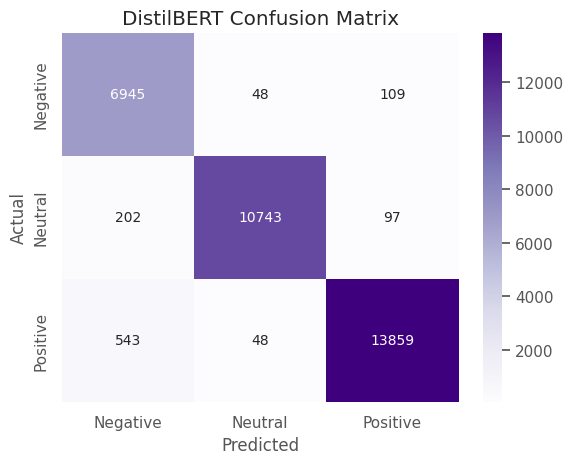

In [28]:
# Confusion matrix
cm_bert = confusion_matrix(y_test_bert, y_pred_bert)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Negative','Neutral','Positive'],
            yticklabels=['Negative','Neutral','Positive'])
plt.title("DistilBERT Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 9. Conclusion
We compare the final accuracy scores of all three models. As expected, the Transformer-based model (DistilBERT) significantly outperforms classical approaches, though at the cost of higher computational resources.

In [30]:
# ===============================
# Model Comparison Table
# ===============================

comparison_df = pd.DataFrame({"Model": ["Logistic Regression", "Naive Bayes", "DistilBERT"],"Type": ["Classical ML", "Classical ML", "Transformer"],"Accuracy": [accuracy_score(y_test, y_pred_lr),accuracy_score(y_test, y_pred_nb),np.mean(y_pred_bert == y_test_bert)]})

comparison_df

,Model,Type,Accuracy
0,Logistic Regression,Classical ML,0.884427
1,Naive Bayes,Classical ML,0.710345
2,DistilBERT,Transformer,0.967878
